In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

In [2]:
hotel_df = pd.read_csv('Hotel Reservations.csv')
hotel_df.drop(['Booking_ID'], inplace=True, axis=1)

### EDA

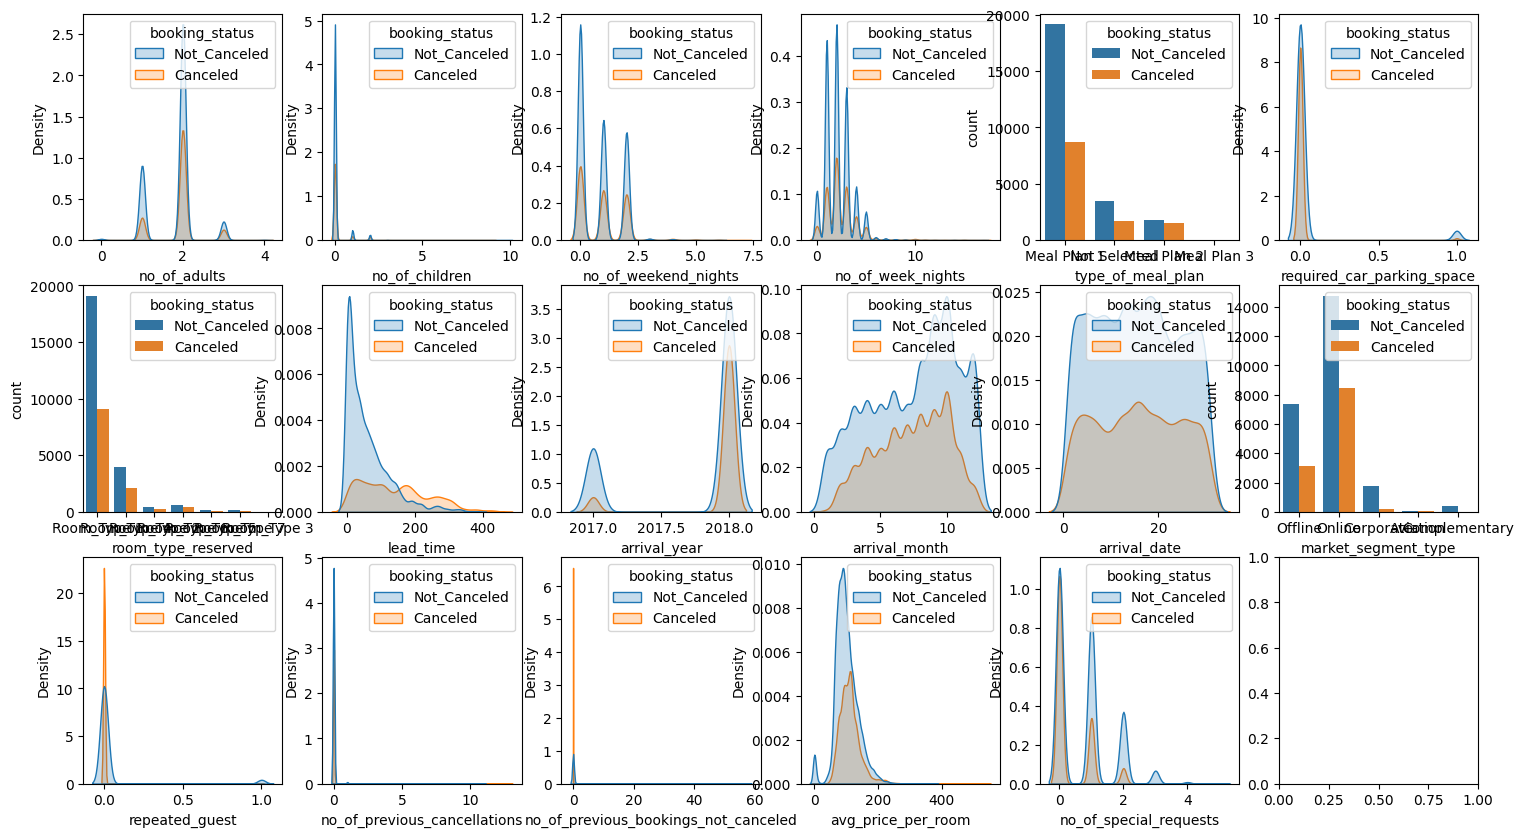

In [3]:
fig, axes = plt.subplots(3, 6, figsize=(18, 10))
i, j = 0, 0
for col, dt in zip(hotel_df.columns[:-1], hotel_df.dtypes[:-1]):
    try:
        sns.kdeplot(ax=axes[i,j], data=hotel_df, x=col, hue='booking_status', fill=True)
    except:
        sns.countplot(ax = axes[i,j], data=hotel_df, x=col, hue='booking_status')
    if j < 5:
        j += 1
    else:
        j = 0
        i += 1

plt.show()

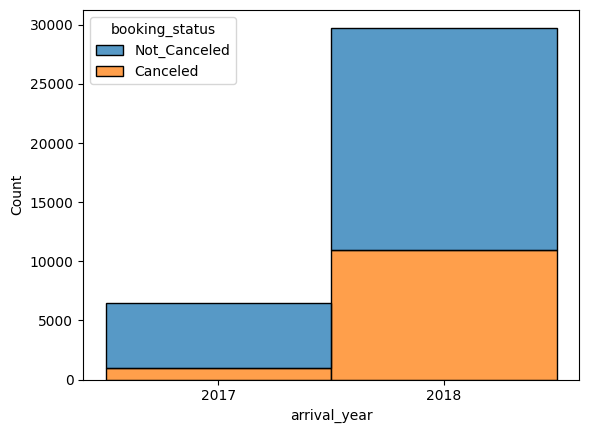

In [4]:
sns.histplot(data=hotel_df, x='arrival_year', hue='booking_status', discrete=True, multiple='stack')
plt.xticks([2017, 2018], ['2017', '2018'])
plt.show()

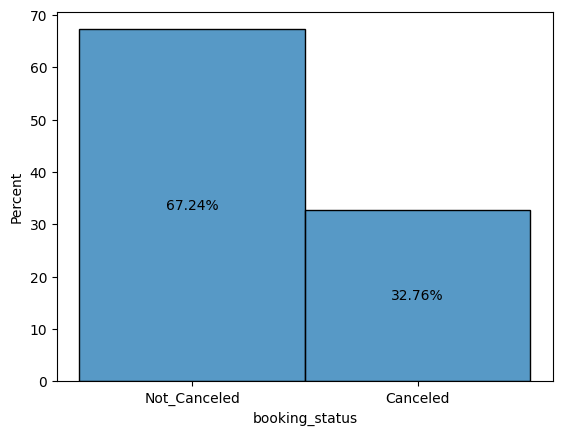

In [5]:
# proportions of Cancelled and Not Cancelled
booking_status = hotel_df['booking_status']
ax = sns.histplot(booking_status, stat='percent')
ax.bar_label(ax.containers[1], fmt='%.2f%%', label_type='center')
plt.show()

### Preprocessing

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [7]:
categorical_vars = ['type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved', 'market_segment_type']
numerical_vars = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'lead_time', 'repeated_guest', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests']
time_vars = ['arrival_year', 'arrival_month', 'arrival_date']

excluded_vars = ['arrival_year']

included_categorical_vars = [var for var in categorical_vars if var not in excluded_vars]
included_numerical_vars = [var for var in numerical_vars if var not in excluded_vars]
included_time_vars = [var for var in time_vars if var not in excluded_vars]

X = hotel_df.drop(['booking_status'] + excluded_vars, axis=1)
y = hotel_df['booking_status']

ct = ColumnTransformer([
    ('Encoder', OneHotEncoder(), included_categorical_vars),
    ('Scaler', StandardScaler(), included_numerical_vars+included_time_vars)], 
    remainder='passthrough')

X_scaled = ct.fit_transform(X)

y_bin = LabelBinarizer().fit_transform(y)
# ### 0: Cancelled, 
# ### 1: Not Cancelled

In [8]:
pickle.dump(ct, open('Models/scaler.pkl', 'wb'))

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_bin, test_size=0.2, random_state=92)

### Neural Network

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [9]:
def create_model(neurons_per_layer, drs, lr, epochs, batch_size, seed, X_train, X_test, y_train, y_test):
    input_dim = X_train.shape[1]

    # define the network architecture
    model = Sequential()
    model.add(Dense(neurons_per_layer[0], input_shape=(input_dim,), activation='relu'))
    if drs[0] != 0:
        model.add(Dropout(drs[0], seed=seed))
    if len(neurons_per_layer) > 1:
        for neurons, dr in zip(neurons_per_layer[1:], drs[1:]):
            model.add(Dense(neurons, activation='relu'))
            if dr != 0:
                model.add(Dropout(dr, seed=seed))
    model.add(Dense(1, activation='sigmoid'))

    # compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
                  loss=tf.keras.losses.binary_crossentropy, 
                  metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

    # train the model
    history = model.fit(
        x = X_train,
        y = y_train,
        batch_size = batch_size,
        epochs = epochs,
        steps_per_epoch = X_train.shape[0]//batch_size,
        validation_data = (X_test, y_test)
        )

    return model, history

In [ ]:
model, history = create_model(neurons_per_layer=[100, 50], drs=[0.15, 0.15], lr=0.005, epochs=100, batch_size=32, seed=886, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

##############################################

plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

print(f'Validation Accuracy: {history.history["val_accuracy"][-1]}')
print(f'Validation Loss: {history.history["val_loss"][-1]}')

In [11]:
model_version = 1

# model filepath
path = f'Models/Model {model_version}'

# check if filepath exists
if not os.path.exists(path):
    os.makedirs(path)

# save model
model.save(f'Models/Model {model_version}/hotel_reservation_{model_version}.h5')

# save model training history
with open(f'Models/Model {model_version}/trainHistoryDict_{model_version}', 'wb') as f:
    pickle.dump(history.history, f)

In [ ]:
## Load training history
# with open('filepath', "rb") as file_pi:
#     history = pickle.load(file_pi)

In [8]:
with open('Models/Model 1/trainHistoryDict_1', "rb") as file_pi:
    test_history = pickle.load(file_pi)

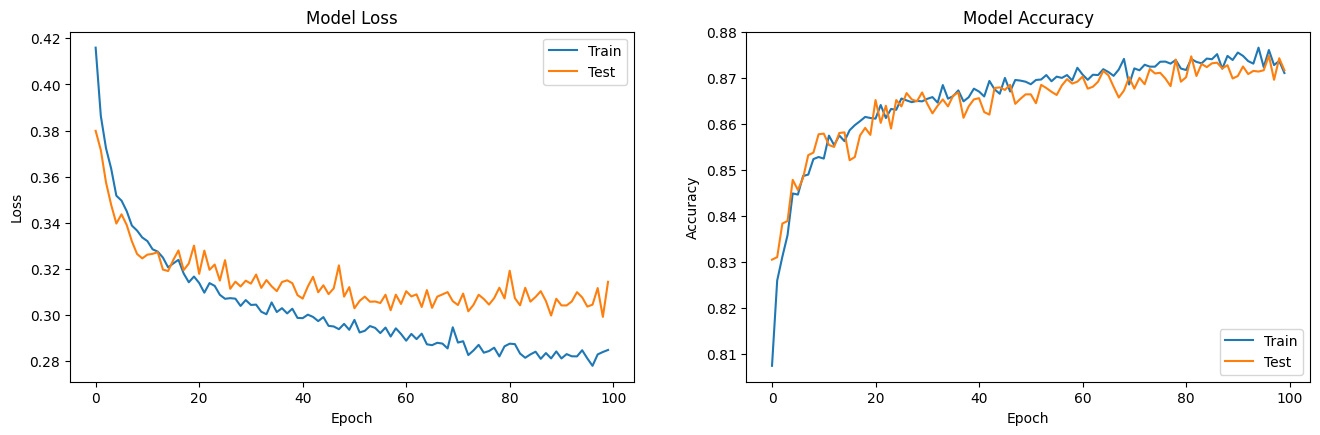

In [9]:
plt.figure(figsize=(16,10))

plt.subplot(2,2,1)
plt.plot(test_history['loss'])
plt.plot(test_history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

plt.subplot(2,2,2)
plt.plot(test_history['accuracy'])
plt.plot(test_history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

In [ ]:
def seed_test(s):
    model, history = create_model(neurons_per_layer=[128, 64], drs=[0.2, 0.2], lr=0.005, epochs=100, batch_size=32, seed=s, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
    score = sum((np.array(history.history['val_loss']) - np.array(history.history['loss']))**2)
    return (s, score)

def run_seed_tests(n):
    results = []
    for i in np.random.choice(1000, n, replace=False):
        results.append(seed_test(i))
    return min(results, key=lambda x: x[1])

print(run_seed_tests(100))

### Model Performance

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [11]:
## load model
model_version = 1
model_test = tf.keras.models.load_model(f'Models/Model {model_version}/hotel_reservation_{model_version}.h5', compile=False)
model_test.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), 
                loss=tf.keras.losses.binary_crossentropy, 
                metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

##### Training Data

In [11]:
thresh=0.5
# Get the predicted labels
y_pred_train = model_test.predict(X_train)
y_pred_train = np.where(y_pred_train >= thresh, 1, 0)

907/907 [==============================] - 1s 1ms/step


In [12]:
# accuracy, precision, & recall of training data
print(f"Accuracy:  {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Precision:  {precision_score(y_train, y_pred_train):.4f}")
print(f"Recall:  {recall_score(y_train, y_pred_train):.4f}")

Accuracy:  0.8858
Precision:  0.8803
Recall:  0.9607


In [13]:
#Calculate confusion matrix
cm_train = confusion_matrix(y_train, y_pred_train)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm_train)

# Extract TP, TN, FP, FN from the confusion matrix
TP_train = cm_train[1, 1]
TN_train = cm_train[0, 0]
FP_train = cm_train[0, 1]
FN_train = cm_train[1, 0]

# Print the results
print(f"\nTrue Positive (TP): {TP_train} ({100*TP_train/y_train.shape[0]:.2f}%)")
print(f"True Negative (TN): {TN_train} ({100*TN_train/y_train.shape[0]:.2f}%)")
print(f"False Positive (FP): {FP_train} ({100*FP_train/y_train.shape[0]:.2f}%)")
print(f"False Negative (FN): {FN_train} ({100*FN_train/y_train.shape[0]:.2f}%)")

Confusion Matrix:
[[ 6967  2548]
 [  767 18738]]

True Positive (TP): 18738 (64.57%)
True Negative (TN): 6967 (24.01%)
False Positive (FP): 2548 (8.78%)
False Negative (FN): 767 (2.64%)


In [17]:
print(classification_report(y_train, y_pred_train, target_names=['Cancelled', 'Not Cancelled']))

               precision    recall  f1-score   support

    Cancelled       0.90      0.73      0.81      9515
Not Cancelled       0.88      0.96      0.92     19505

     accuracy                           0.89     29020
    macro avg       0.89      0.85      0.86     29020
 weighted avg       0.89      0.89      0.88     29020



##### Testing Data

In [18]:
thresh=0.5
# Get the predicted labels
y_pred_test = model_test.predict(X_test)
y_pred_test = np.where(y_pred_test >= thresh, 1, 0)

227/227 [==============================] - 0s 580us/step


In [19]:
# accuracy, precision, & recall of testing data
print(f"Accuracy:  {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Precision:  {precision_score(y_test, y_pred_test):.4f}")
print(f"Recall:  {recall_score(y_test, y_pred_test):.4f}")

Accuracy:  0.8717
Precision:  0.8706
Recall:  0.9507


In [20]:
#Calculate confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm_test)

# Extract TP, TN, FP, FN from the confusion matrix
TP_test = cm_test[1, 1]
TN_test = cm_test[0, 0]
FP_test = cm_test[0, 1]
FN_test = cm_test[1, 0]

# Print the results
print(f"\nTrue Positive (TP): {TP_test} ({100*TP_test/y_test.shape[0]:.2f}%)")
print(f"True Negative (TN): {TN_test} ({100*TN_test/y_test.shape[0]:.2f}%)")
print(f"False Positive (FP): {FP_test} ({100*FP_test/y_test.shape[0]:.2f}%)")
print(f"False Negative (FN): {FN_test} ({100*FN_test/y_test.shape[0]:.2f}%)")

Confusion Matrix:
[[1680  690]
 [ 241 4644]]

True Positive (TP): 4644 (64.01%)
True Negative (TN): 1680 (23.16%)
False Positive (FP): 690 (9.51%)
False Negative (FN): 241 (3.32%)


In [22]:
print(classification_report(y_test, y_pred_test, target_names=['Cancelled', 'Not Cancelled']))

               precision    recall  f1-score   support

    Cancelled       0.87      0.71      0.78      2370
Not Cancelled       0.87      0.95      0.91      4885

     accuracy                           0.87      7255
    macro avg       0.87      0.83      0.85      7255
 weighted avg       0.87      0.87      0.87      7255



### Gridsearch

In [10]:
def define_model(neurons_per_layer, drs, lr, seed):
    model = Sequential()
    model.add(Dense(neurons_per_layer[0], activation='relu', input_shape=(X_train.shape[1],)))
    if drs[0] != 0:
        model.add(Dropout(drs[0], seed=seed))
    if neurons_per_layer[1:]:
        for neurons, dr in zip(neurons_per_layer[1:], drs[1:]):
            model.add(Dense(neurons, activation='relu'))
            if dr != 0:
                model.add(Dropout(dr, seed=seed))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
                  loss=tf.keras.losses.binary_crossentropy, 
                  metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

    return model

In [11]:
param_grid = {
    'lr': [0.005, 0.01, 0.03],
    'drs': [[0.1, 0.1], [0.15, 0.15], [0.2, 0.2], [0.3, 0.3]],
    'neurons_per_layer': [[256, 128], [200, 100], [128, 64], [100, 50], [80, 40]],
    'seed': [886]
}

grid_model = KerasClassifier(build_fn=define_model, epochs=100, batch_size=32, verbose=0)

grid = GridSearchCV(estimator=grid_model, param_grid=param_grid, n_jobs=6, cv=3)

grid_result = grid.fit(X_train, y_train)

print("Best parameters: ", grid_result.best_params_)
print("Best accuracy: {:.2f}%".format(grid_result.best_score_ * 100))

C:\Users\Connor\AppData\Local\Temp\ipykernel_18600\2866638661.py:8: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model_2 = KerasClassifier(build_fn=define_model, epochs=100, batch_size=32, verbose=0)
c:\Users\Connor\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters:  {'drs': [0.15, 0.15], 'lr': 0.005, 'neurons_per_layer': [100, 50], 'seed': 886}
Best accuracy: 87.03%
